In [11]:
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate


In [12]:
conn = psycopg2.connect(database="keep_data", user="postgres", password="postgres", host="localhost", port="5432")
cur = conn.cursor()
df = psql.read_sql("Select * from markets_data", conn)
del df['time']
df.tail()


,open_b,close_b,high_b,low_b,vol_b,vol_conv_b,open,close,high,low,vol,vol_conv,average,cnt
131,0.002678,0.002636,0.002981,0.002634,94422.50,262.047152,0.950793,0.957103,1.013577,0.949185,8.785412e+05,858786.825244,0.977515,304
132,0.002634,0.002434,0.002642,0.002405,84130.99,213.199559,0.957103,0.871108,0.961920,0.871108,9.269532e+05,851081.066239,0.918149,360
133,0.002435,0.002409,0.002491,0.002250,87318.12,206.943402,0.870567,0.849662,0.894629,0.785943,1.104292e+06,943948.193312,0.854800,476
134,0.002411,0.002164,0.002429,0.002148,78258.98,175.604747,0.849822,0.781785,0.850283,0.777999,1.145492e+06,930391.386496,0.812220,512
135,0.002166,0.002162,0.002268,0.002162,37520.25,82.009825,0.784538,0.820020,0.826006,0.780849,1.022801e+06,824220.199903,0.805846,104


In [13]:
history_points = 10
data = df
data = data[::-1]
data = data.reset_index()
data = data.drop('index', axis=1)
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)
ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:,1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
next_day_open_values = np.array([data.loc[:,"close_b"][i + history_points].copy() for i in range(len(data) - history_points)])
next_day_open_values_save = next_day_open_values.copy()
next_day_open_values = np.expand_dims(next_day_open_values, -1)
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)

assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]

ohlcv_histories = ohlcv_histories_normalised
next_day_open_values = next_day_open_values_normalised
unscaled_y = next_day_open_values
y_scaler = y_normaliser

In [14]:
test_split = 0.8
n = int(ohlcv_histories.shape[0] * test_split)
ohlcv_train = ohlcv_histories[:n]
 # add technical indicator
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
 # add technical indicator
y_test = next_day_open_values[n:]

unscaled_y_test = next_day_open_values_save[n:]
print(ohlcv_train.shape)

(100, 10, 14)


In [15]:
lstm_input = Input(shape=(history_points, 14), name='lstm_input')
DROPOUT = 0.2
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.Bidirectional(LSTM(200, return_sequences=True), input_shape=(10, ohlcv_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(tensorflow.keras.layers.Bidirectional(LSTM((200 * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))
model.add(tensorflow.keras.layers.Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))
BATCH_SIZE = 64
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 10, 400)           344000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 400)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 10, 800)           2563200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 800)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 400)               1601600   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                

In [7]:
# Build Model (RNN)
lstm_input = Input(shape=(history_points, 14), name='lstm_input')

x = LSTM(200, name='lstm_0')(lstm_input)
x = Dropout(0.7, name='lstm_dropout_0')(x)

# the second branch opreates on the second input
lstm_branch = Model(inputs=lstm_input, outputs=x)

z = Dense(256, activation="sigmoid", name='dense_pooling')(lstm_branch.output)
z = Dense(1, activation="linear", name='dense_out')(z)

# this model will accept the inputs of the two branches and then output a single value
model = Model(inputs=lstm_branch.input, outputs=z)

model.summary()
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 10, 14)]          0         
_________________________________________________________________
lstm_0 (LSTM)                (None, 200)               172000    
_________________________________________________________________
lstm_dropout_0 (Dropout)     (None, 200)               0         
_________________________________________________________________
dense_pooling (Dense)        (None, 256)               51456     
_________________________________________________________________
dense_out (Dense)            (None, 1)                 257       
Total params: 223,713
Trainable params: 223,713
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Train Model
num_epochs = 300
batch_size = 64
history = model.fit(x=ohlcv_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, validation_split=0.1)

Train on 90 samples, validate on 10 samples
Epoch 1/300
90/90 [==============================] - 18s 204ms/sample - loss: 0.0887 - val_loss: 7.8070e-04
Epoch 2/300
90/90 [==============================] - 2s 20ms/sample - loss: 0.0106 - val_loss: 0.0327
Epoch 3/300
90/90 [==============================] - 4s 46ms/sample - loss: 0.0246 - val_loss: 0.0083
Epoch 4/300
90/90 [==============================] - 2s 19ms/sample - loss: 0.0046 - val_loss: 0.0014
Epoch 5/300
90/90 [==============================] - 2s 21ms/sample - loss: 0.0084 - val_loss: 0.0014
Epoch 6/300
90/90 [==============================] - 2s 20ms/sample - loss: 0.0072 - val_loss: 0.0019
Epoch 7/300
90/90 [==============================] - 2s 21ms/sample - loss: 0.0026 - val_loss: 0.0075

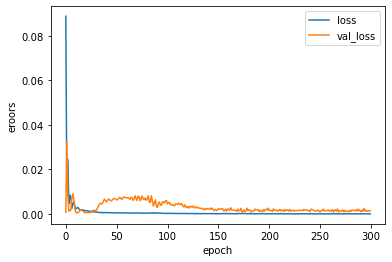

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('eroors')
plt.legend()
plt.show()

26/26 [==============================] - 0s 12ms/sample - loss: 0.0018
0.0017679639859125018
0.15919481571346436


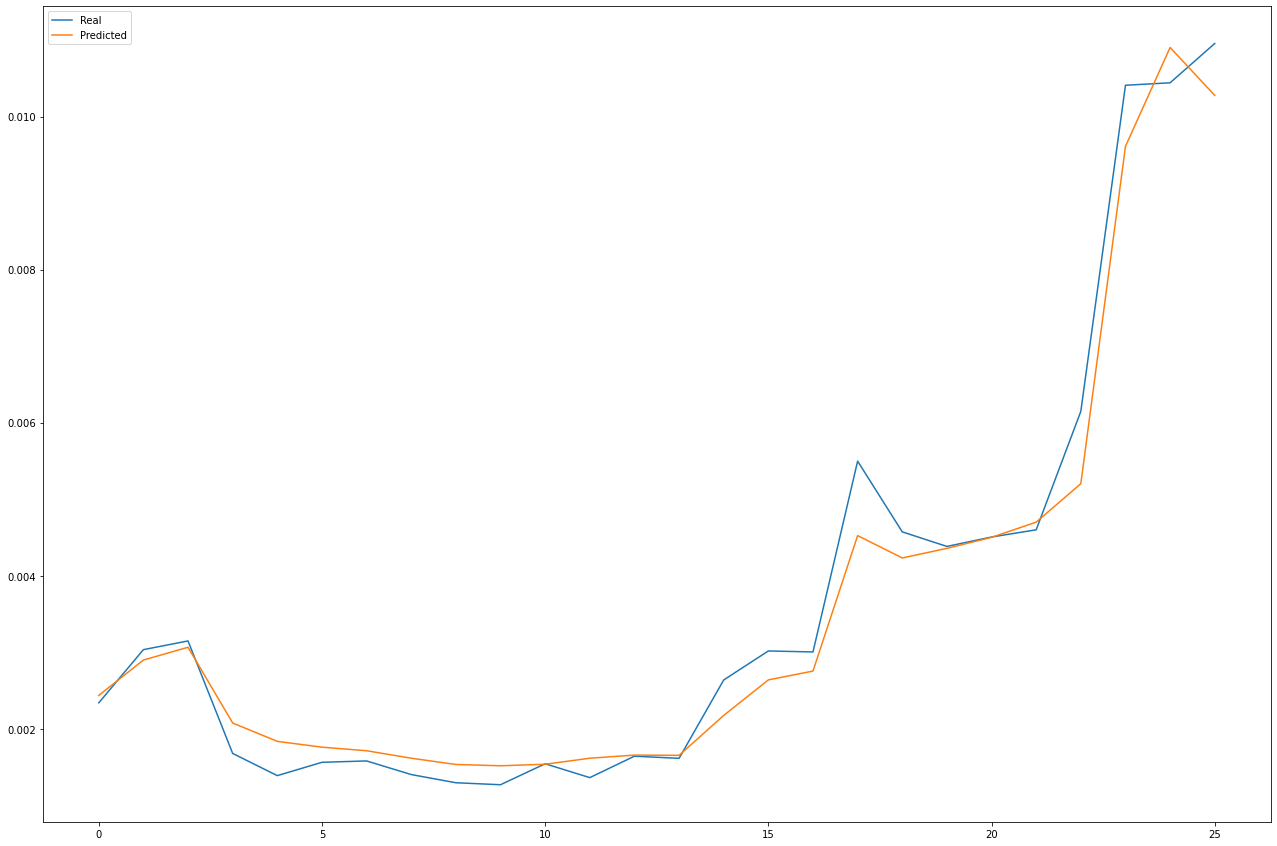

In [18]:
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_scaler.inverse_transform(y_predicted)
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

plt.gcf().set_size_inches(22, 15, forward=True)
start = 0
end = -1
real = plt.plot(unscaled_y_test, label='real')
pred = plt.plot(y_test_predicted, label='predicted')
plt.legend(['Real', 'Predicted'])
plt.show()



In [19]:
model.save("models\keep_predit_lstm.h5")